# CASE BASED CLASSIFICATION

This notebook develops the idea of case base classiication (cb-clf). This involves:
1. Identify sets of feature that provide good classification accuracy. There may be many.
1. Given a new feature vector, provide evidence for the difference classes to which it may belong.

## Imports

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet
from common import trinary_data

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import svm

%matplotlib inline

## Constants

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
PROVIDER = DataProvider()
PROVIDER.do()
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
REGULATORS = DF_X.columns.tolist()
DATA_PATH = cn.PROJECT_DIR
for directory in ["data", "feature_analyzer"]:
    DATA_PATH = os.path.join(DATA_PATH, directory)
DATA_PATH_PAT = os.path.join(DATA_PATH, "%d") 
ANALYZER_DCT = feature_analyzer.deserialize({s: DATA_PATH_PAT % s for s in STATES})
ANALYZERS = ANALYZER_DCT.values()
COLLECTION_DCT = {s: feature_set_collection.FeatureSetCollection.deserialize(DATA_PATH_PAT % s) for s in STATES}
_ = [c.ser_comb for c in COLLECTION_DCT.values()]

In [4]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM = SAMPLE_DATA.AM_MDM
DF_AW = SAMPLE_DATA.AW
DF_GALAGAN = SAMPLE_DATA.galagan

## Data

1. The data consistent of individual replicas of read counts at 26 times.
1. Times are labelled with six states, as defined in ``STAGE_DCT``.
1. Raw expression values of normalized w.r.t. time 0 (normal) and transformed as log2 so that there are
25 normalized times that are trinary values defined as:
   * -1 if < -1
   * 1 if > 1
   * 0 otherwise

In [47]:
STAGE_DCT = {}
STAGE_DCT[0] = "Normoxia"
STAGE_DCT[1] = "Transition"
STAGE_DCT[2] = "StageII"
STAGE_DCT[3] = "Stage1a"
STAGE_DCT[4] = "Stage1b"
STAGE_DCT[5] = "Resuscitation"

"""
STAGE_DCT["T1"] = "Normoxia"
STAGE_DCT["T2"] = "Transition"
STAGE_DCT["T3"] = "Transition"
STAGE_DCT["T4"] = "Transition"
STAGE_DCT["T5"] = "Transition"
STAGE_DCT["T6"] = "Transition"
STAGE_DCT["T7"] = "Transition"
STAGE_DCT["T8"] = "StageII"
STAGE_DCT["T9"] = "StageII"
STAGE_DCT["T10"] = "Stage1a"
STAGE_DCT["T11"] = "StageII"
STAGE_DCT["T12"] = "Stage1a"
STAGE_DCT["T13"] = "Stage1a"
STAGE_DCT["T14"] = "Stage1a"
STAGE_DCT["T15"] = "Stage1a"
STAGE_DCT["T16"] = "Stage1b"
STAGE_DCT["T17"] = "Stage1b"
STAGE_DCT["T18"] = "Stage1b"
STAGE_DCT["T19"] = "StageII"
STAGE_DCT["T20"] = "StageII"
STAGE_DCT["T21"] = "StageII"
STAGE_DCT["T22"] = "Resuscitation"
STAGE_DCT["T23"] = "Resuscitation"
STAGE_DCT["T24"] = "Resuscitation"
STAGE_DCT["T25"] = "Resuscitation"
"""
STAGE_DCT

{0: 'Normoxia',
 1: 'Transition',
 2: 'StageII',
 3: 'Stage1a',
 4: 'Stage1b',
 5: 'Resuscitation'}

# Feature Sets

A feature set is a collection of features used to train a classifier.
There may be many feature sets that result in accurate classification in expression data
because of the high interelatedness of gene expression.

We consider separate feature sets for each state of gene expression.

In [53]:
# First 10 feature sets for Normoxia (state 0)
COLLECTION_DCT[0]._ser_sbfset.index[0:10]

Index(['Rv3246c+Rv3260c', 'Rv0117+Rv1219c', 'Rv0117+Rv0827c', 'Rv0117+Rv0894',
       'Rv0117+Rv0302', 'Rv0117+Rv0653c', 'Rv0117+Rv3219', 'Rv0117+Rv0135c',
       'Rv0117+Rv3416', 'Rv0117+Rv1176c'],
      dtype='object')

In [54]:
# First 10 feature sets for Transition (state 1)
COLLECTION_DCT[1]._ser_sbfset.index[0:10]

Index(['Rv3095+Rv3246c', 'Rv0474+Rv3246c', 'Rv2009+Rv3246c', 'Rv2021c+Rv3246c',
       'Rv0653c+Rv3246c', 'Rv2009+Rv3830c', 'Rv2009+Rv3066', 'Rv0330c+Rv2009',
       'Rv0158+Rv3246c', 'Rv3082c+Rv3246c'],
      dtype='object')

In [55]:
# First 10 feature sets for Stage 2 (state 2)
COLLECTION_DCT[2]._ser_sbfset.index[0:10]

Index(['Rv0494+Rv3417c', 'Rv0602c+Rv3833', 'Rv1719+Rv3833', 'Rv0602c+Rv2250c',
       'Rv0302+Rv0602c', 'Rv2488c+Rv3133c', 'Rv3095+Rv3246c', 'Rv1719+Rv1773c',
       'Rv0602c+Rv0674', 'Rv0602c+Rv1556'],
      dtype='object')

In [59]:
# Feature sets are evaluated as to their classification accuracy
# for each combination of feature values.
# Here are details about one feature set for each value of the gene expression
# of of the features. Note that the classifier makes predictions for feature values
# even if there is no training data for the feature values.
fset = FeatureSet("Rv3095+Rv3246c", analyzer=COLLECTION_DCT[1]._analyzer)
fset.profileTrinary()

,predicted,count,frac,siglvl_pos,siglvl_neg,feature_set
value,,,,,,
"(-1, -1)",0,2.0,0.00,1.000000,0.000000,Rv3095+Rv3246c
"(-1, 0)",0,22.0,0.00,1.000000,0.000000,Rv3095+Rv3246c
"(-1, 1)",0,11.0,0.00,1.000000,0.000000,Rv3095+Rv3246c
"(0, -1)",0,0.0,NaN,NaN,NaN,Rv3095+Rv3246c
"(0, 0)",0,20.0,0.05,0.999999,0.000020,Rv3095+Rv3246c
"(0, 1)",1,20.0,0.85,0.001288,0.999799,Rv3095+Rv3246c
"(1, -1)",0,0.0,NaN,NaN,NaN,Rv3095+Rv3246c
"(1, 0)",1,0.0,NaN,NaN,NaN,Rv3095+Rv3246c
"(1, 1)",1,0.0,NaN,NaN,NaN,Rv3095+Rv3246c


A **case** is set of values for a feature set.
A case corresponds to a row in the above table.
In general, a case is the combination of a feature set and the values
assigned to the features.

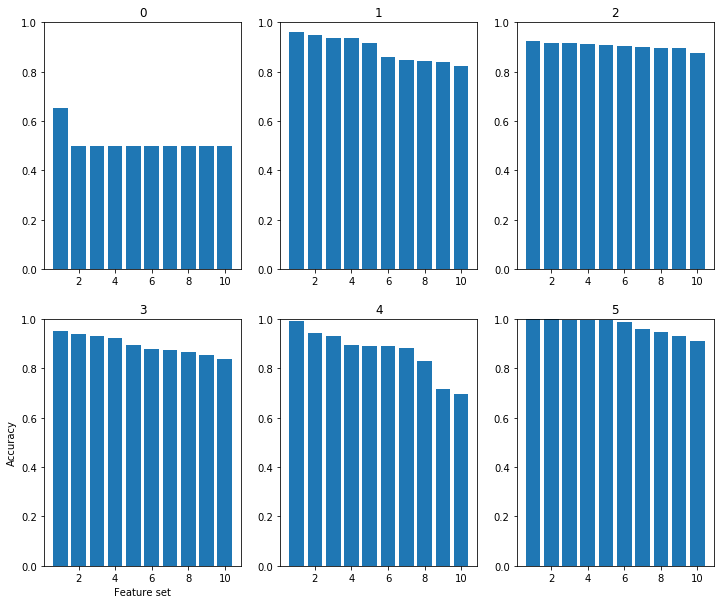

In [56]:
# Plots of the accuracies of the top 10 feature sets for each state
nrow = 2
ncol = 3
xv = range(1, 11)
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 10))
for state in STATES:
    row = int(state/ncol)
    col = state % ncol
    collection = COLLECTION_DCT[state]
    ax = axes[row, col]
    values = collection.ser_comb.to_list()
    ax.bar(xv, values[:len(xv)])
    if state == 3:
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Feature set")
    ax.set_ylim([0, 1])
    ax.set_title("%d" % state)
    
    

# Feature Vector Evaluations

A feature vector evaluation involves finding all cases that apply to the feature vector
and indicating their support for or against a particular state.

In [10]:
 def fullProfile(ser_X, title="", **kwargs):
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            collection = COLLECTION_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            collection.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = "State %d" % idx,
                label_xoffset=label_xoffset, **kwargs)
        fig.suptitle(title, fontsize=16)
        plt.show()

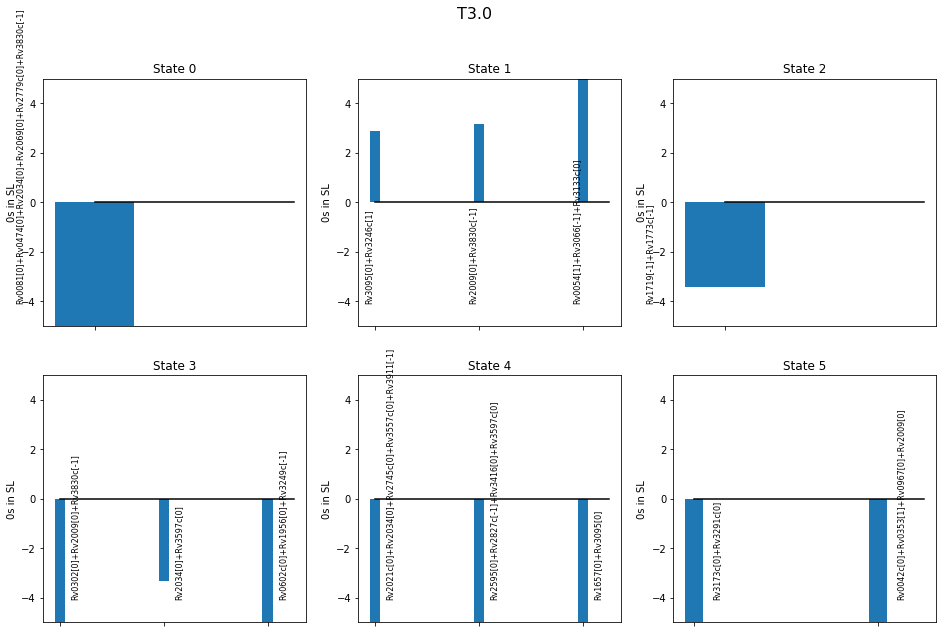

In [62]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instance = "T3.0"
ser_X = DF_X.loc[instance]
fullProfile(ser_X, title=instance)

In [12]:
DF_AW.head()

GENE_ID,Rv3050c,Rv0054,Rv0081,Rv0827c,Rv3246c,Rv1332,Rv3183,Rv0353,Rv3160c,Rv2017,...,Rv2506,Rv3167c,Rv1956,Rv3082c,Rv3173c,Rv1556,Rv1675c,Rv3291c,Rv3223c,Rv1828
AW_plus_1,0,-1,0,0,1,1,-1,0,0,-1,...,-1,-1,0,-1,-1,0,-1,-1,0,0
AW_neg_1,0,-1,0,0,0,1,-1,1,1,-1,...,-1,-1,0,-1,0,-1,-1,0,1,1
AW_plus_3,0,0,1,0,0,0,-1,1,0,0,...,0,-1,0,-1,0,0,-1,0,1,0
AW_neg_3,0,-1,1,0,1,1,-1,0,0,0,...,0,-1,0,-1,0,0,-1,0,0,1
AW_plus_4,0,-1,0,0,1,1,-1,0,1,-1,...,0,-1,0,-1,-1,0,-1,1,1,1


***No fset found that is consistent with the feature vector.


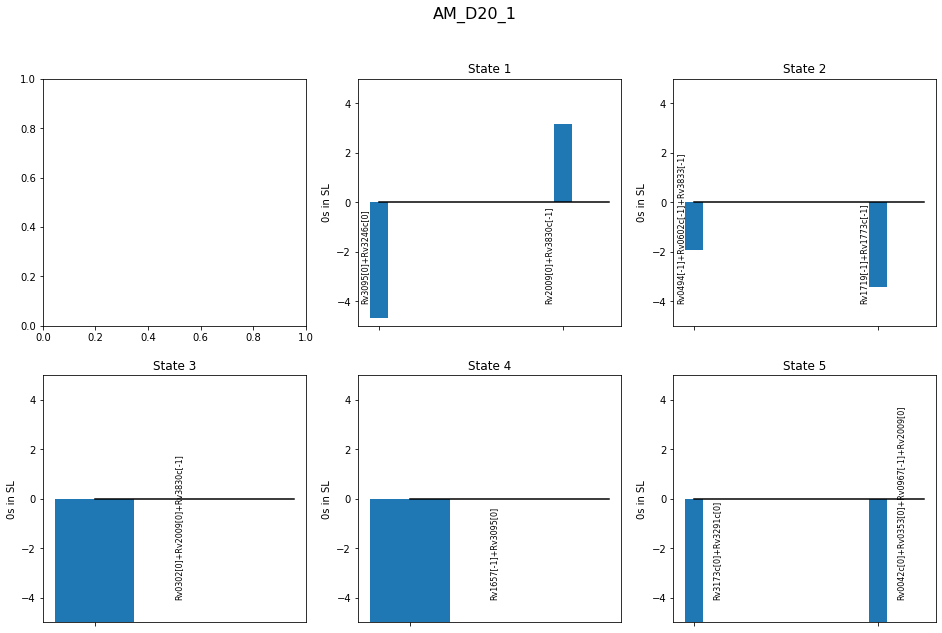

***No fset found that is consistent with the feature vector.


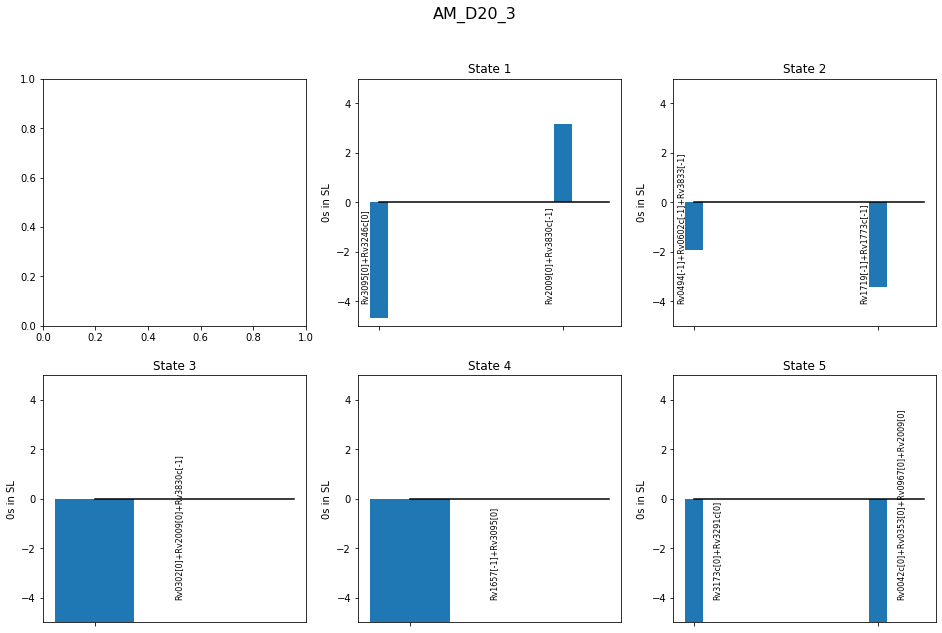

***No fset found that is consistent with the feature vector.


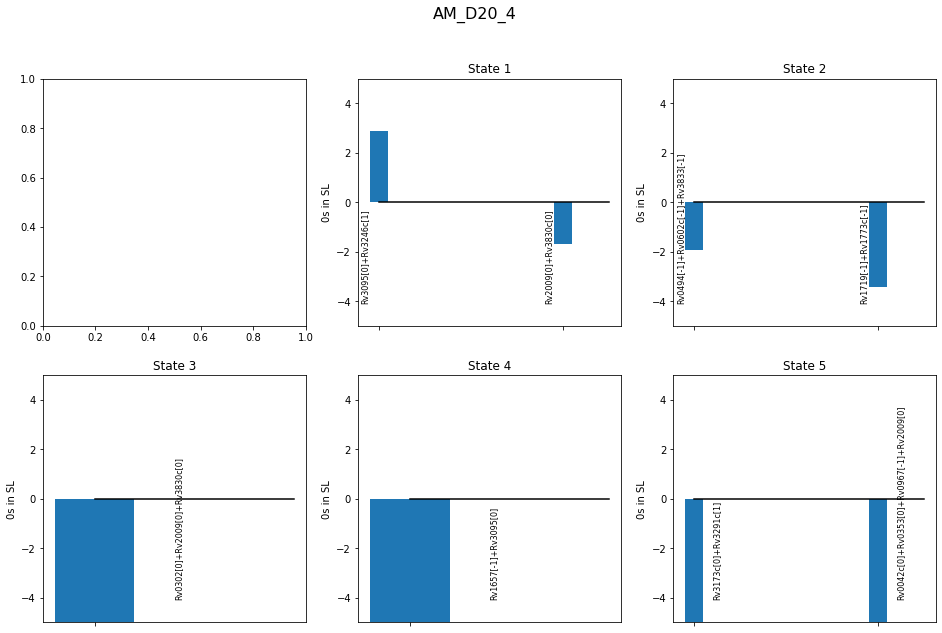

***No fset found that is consistent with the feature vector.


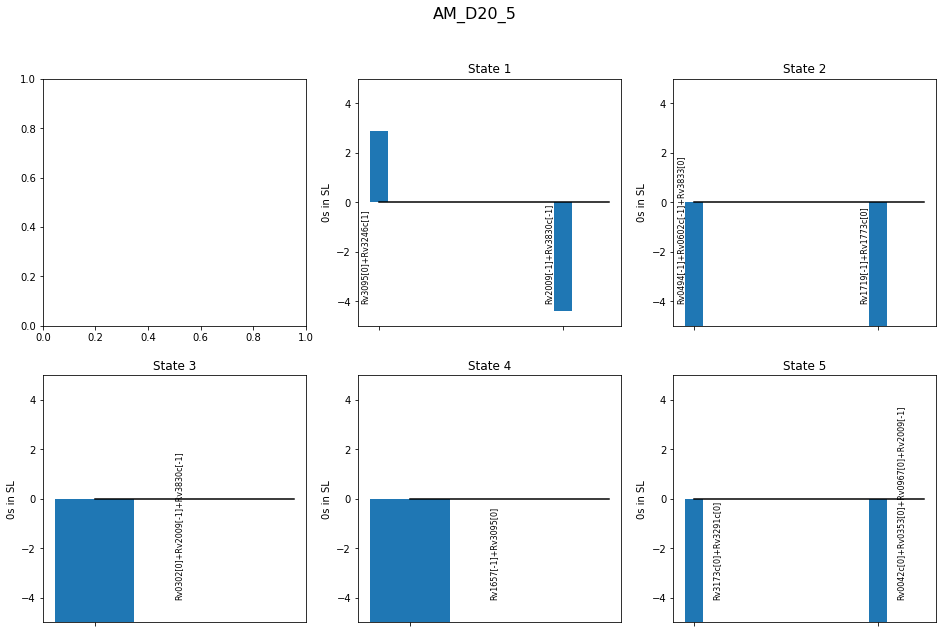

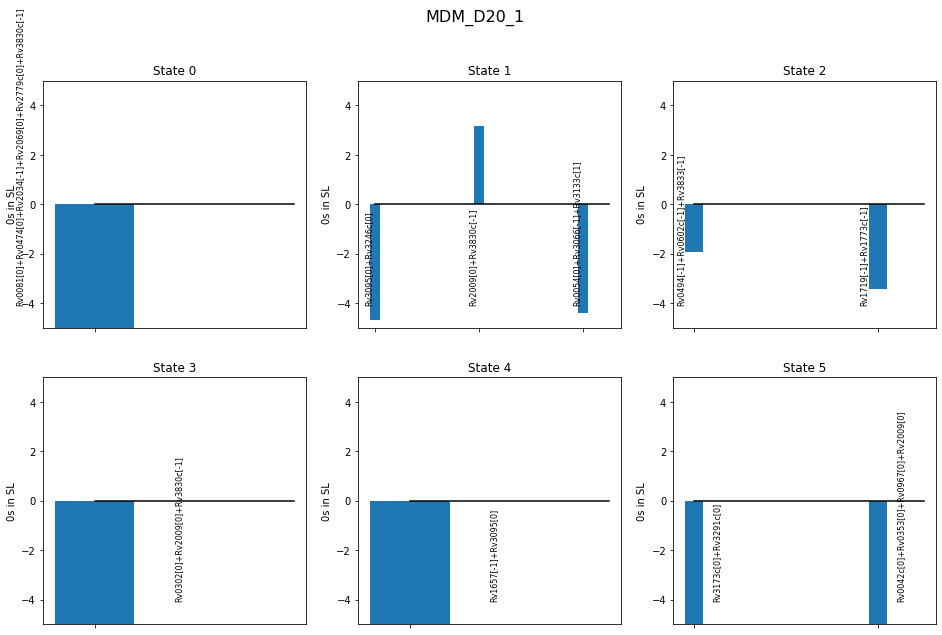

***No fset found that is consistent with the feature vector.


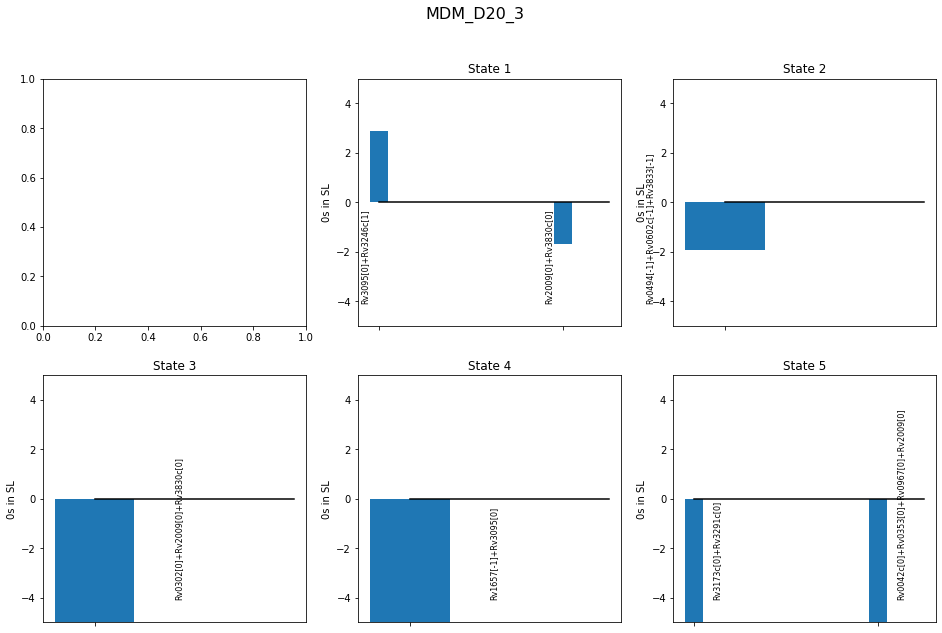

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


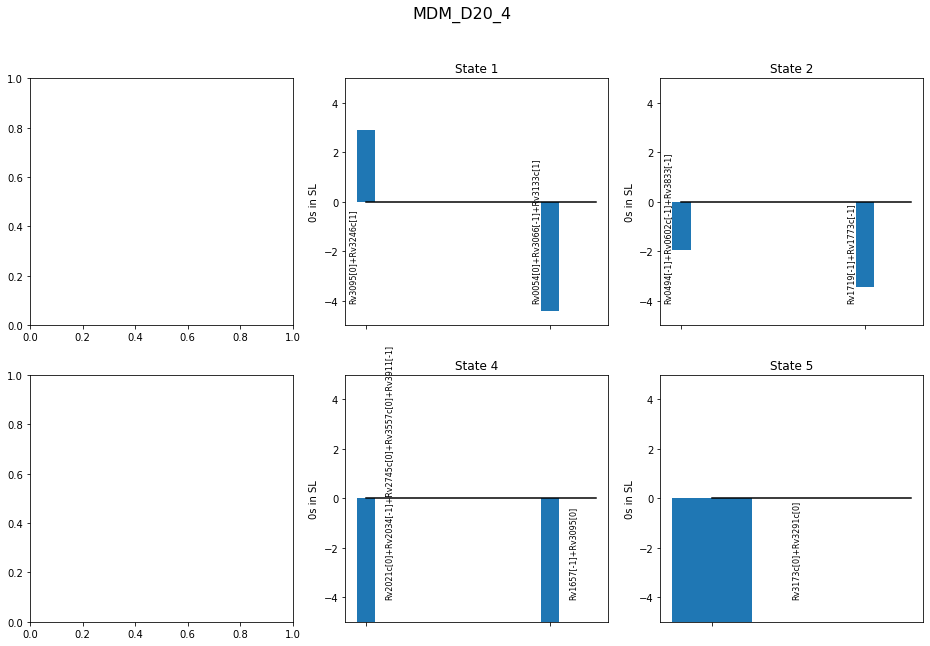

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


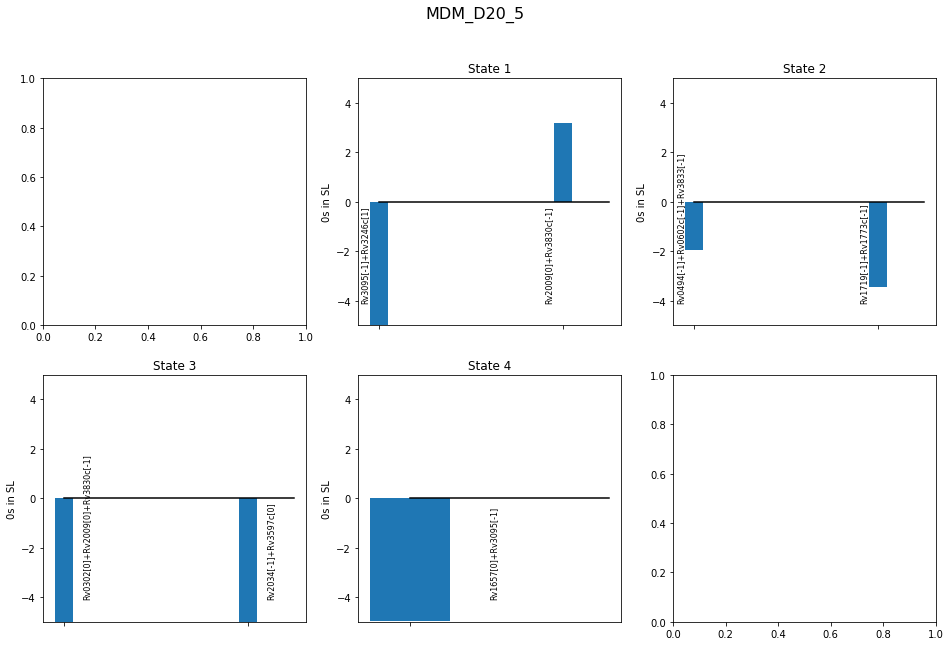

In [13]:
for instance in DF_AM.index:
    ser_X = DF_AM.loc[instance]
    fullProfile(ser_X, title=instance)

***No fset found that is consistent with the feature vector.


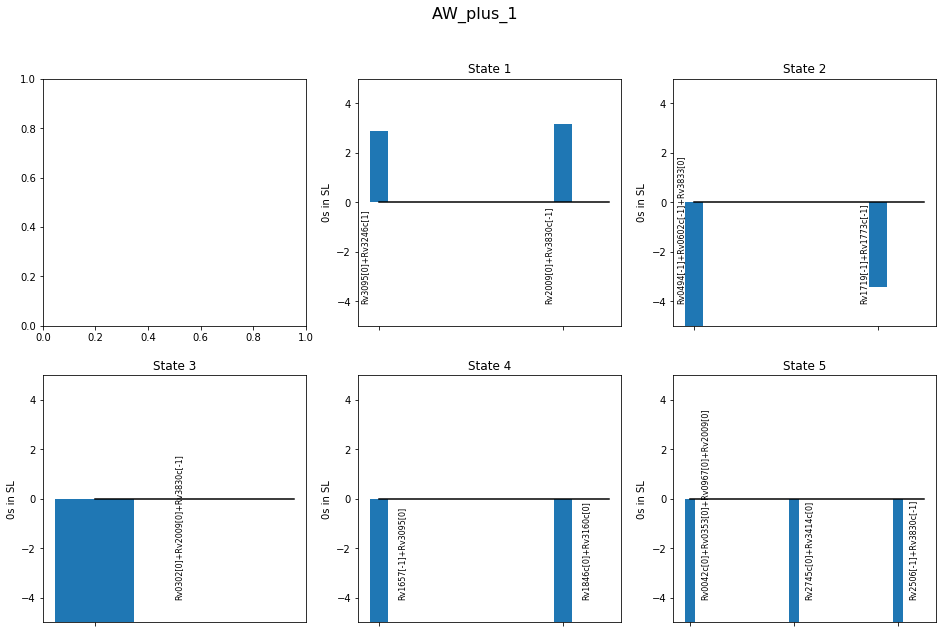

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


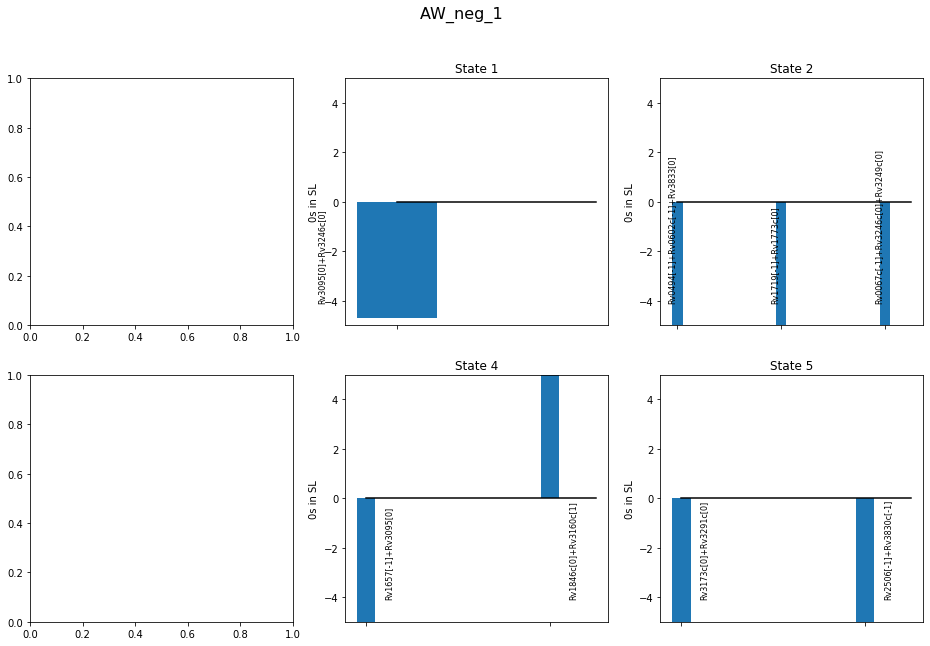

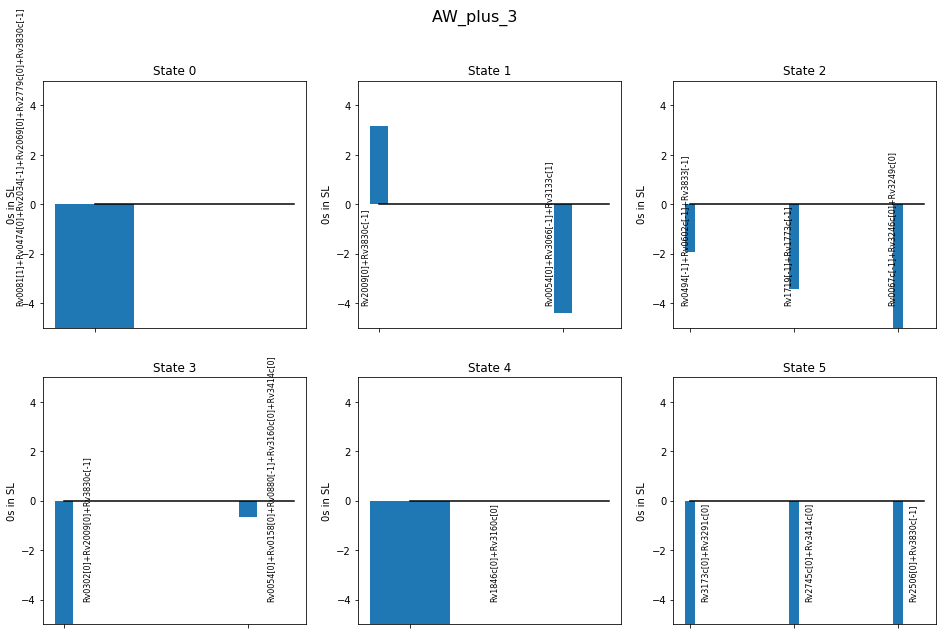

***No fset found that is consistent with the feature vector.


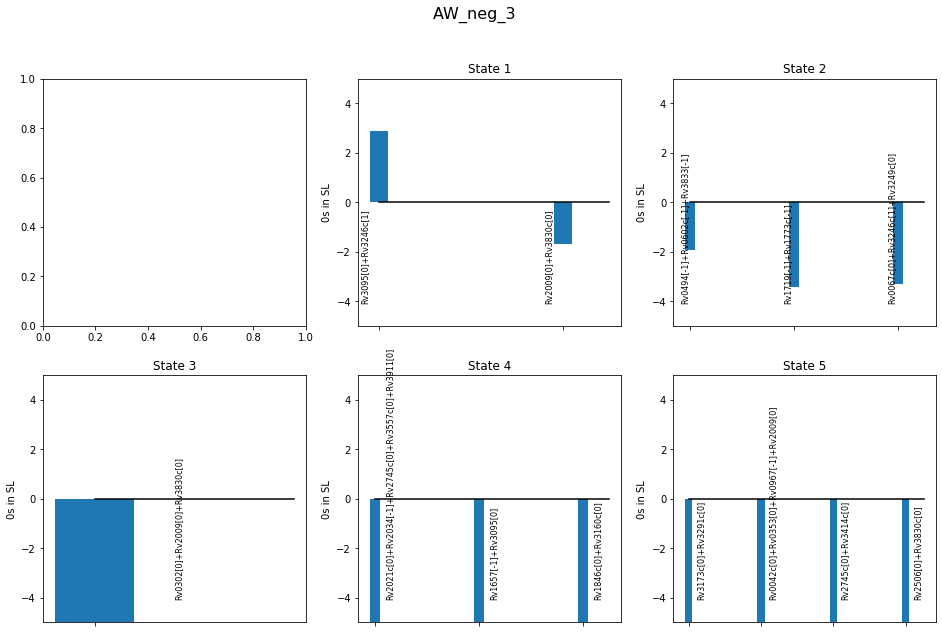

***No fset found that is consistent with the feature vector.


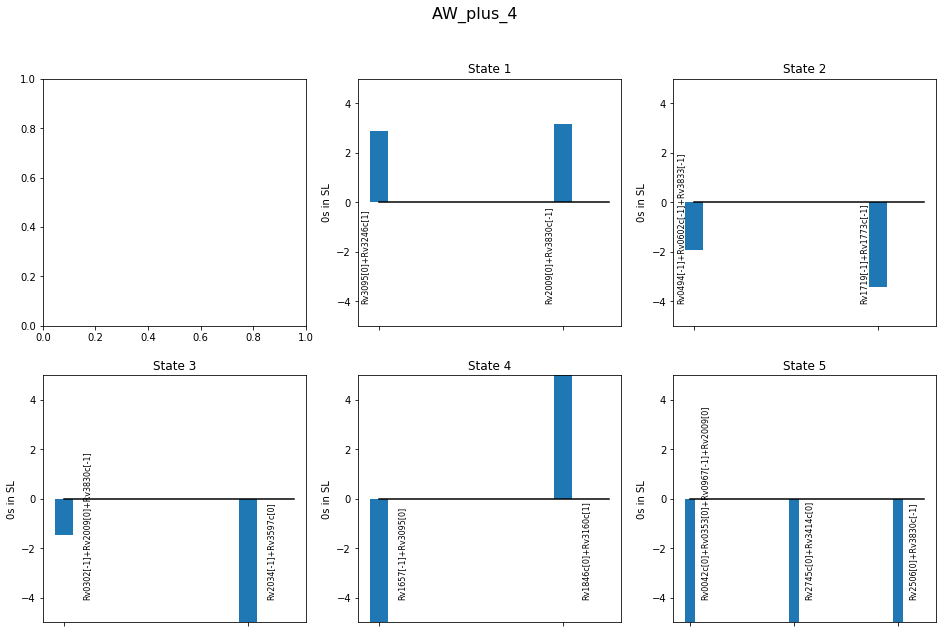

***No fset found that is consistent with the feature vector.


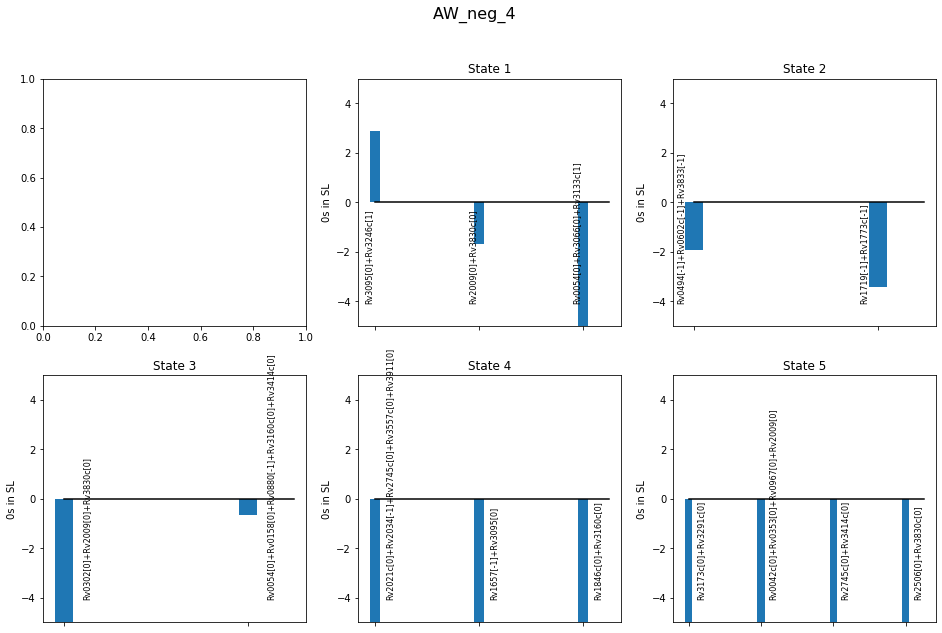

In [14]:
for instance in DF_AW.index:
    ser_X = DF_AW.loc[instance]
    fullProfile(ser_X, title=instance, num_fset=5)

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


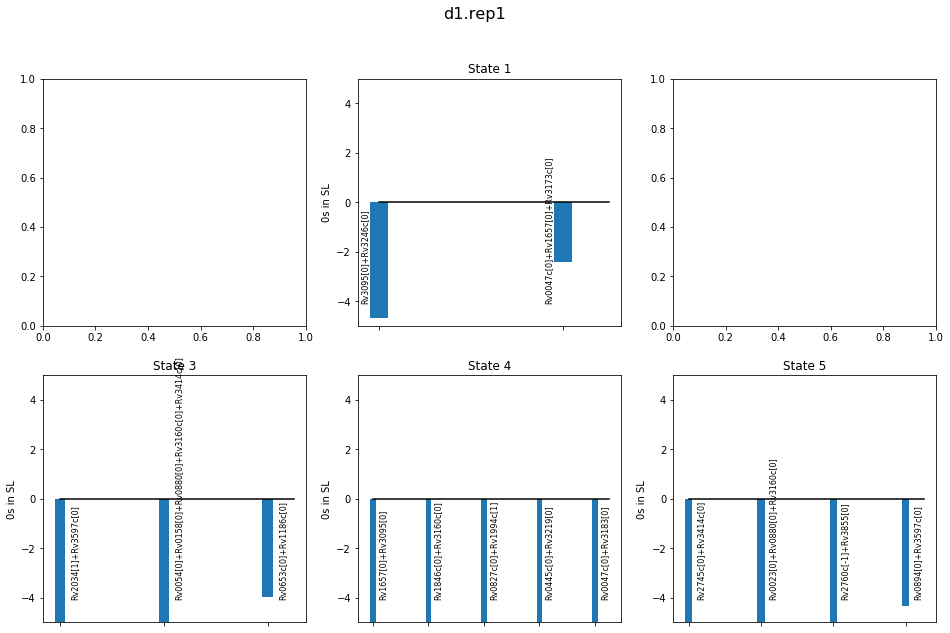

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


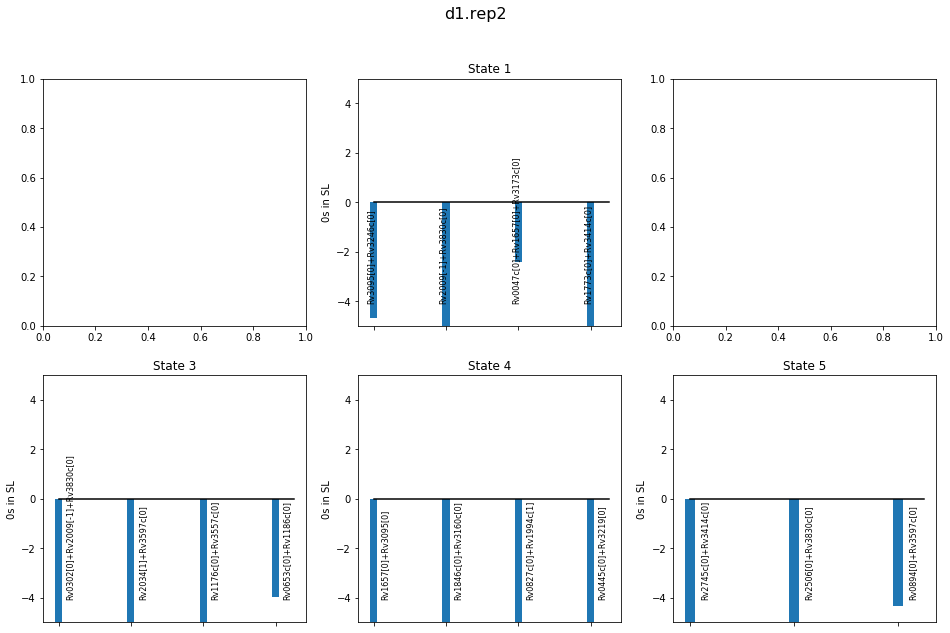

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


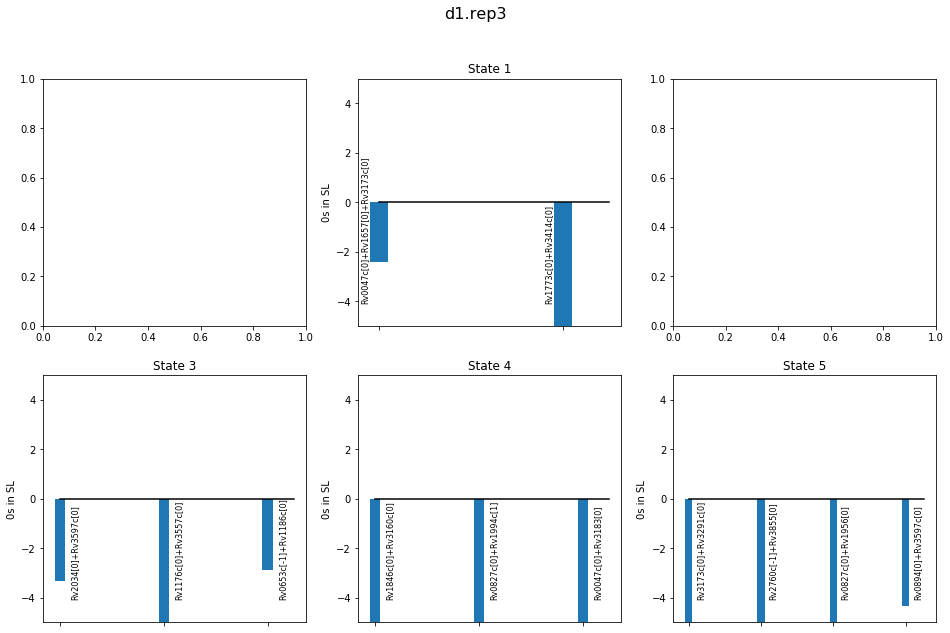

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


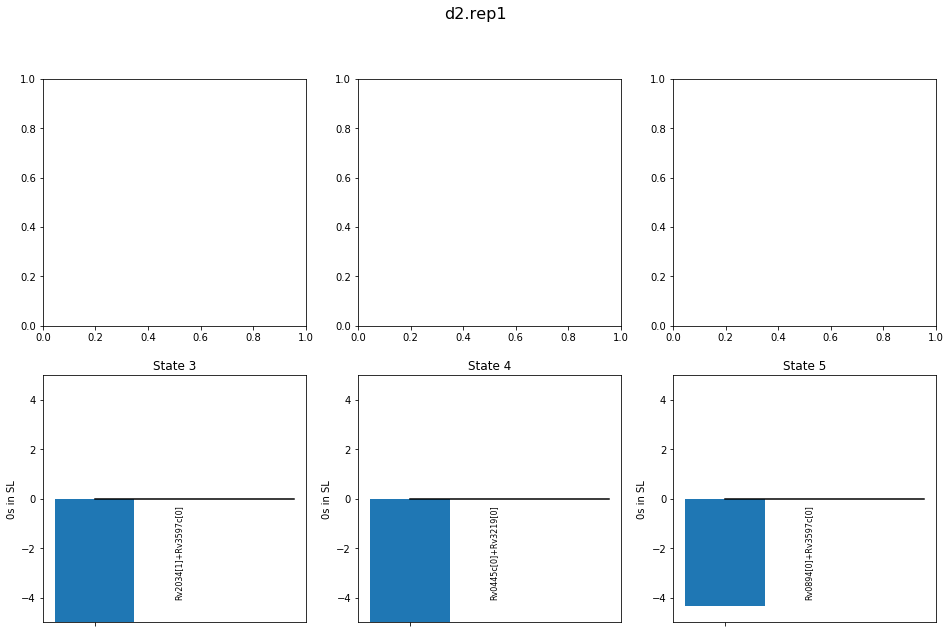

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


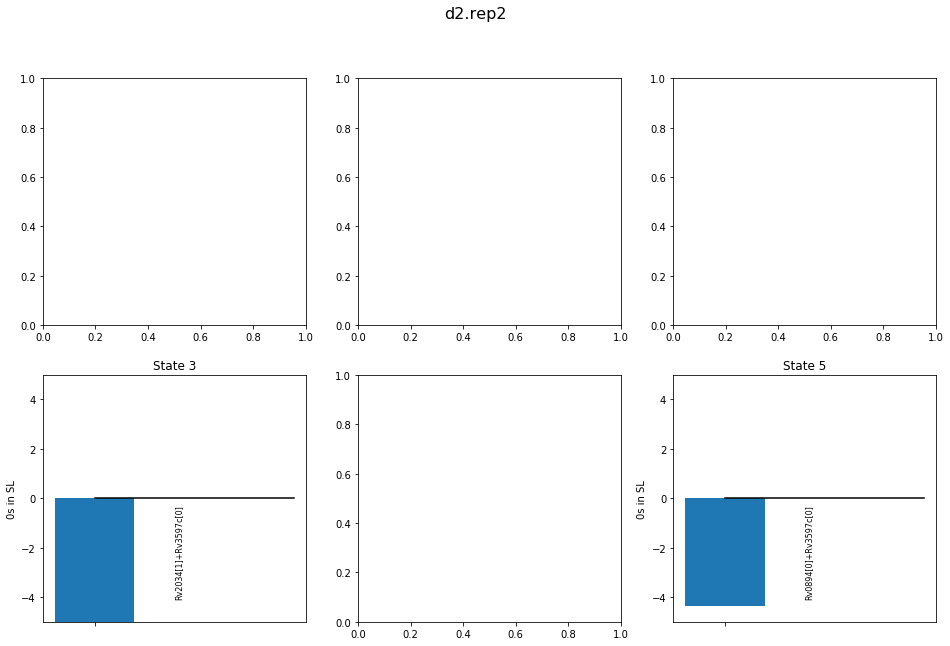

***No fset found that is consistent with the feature vector.


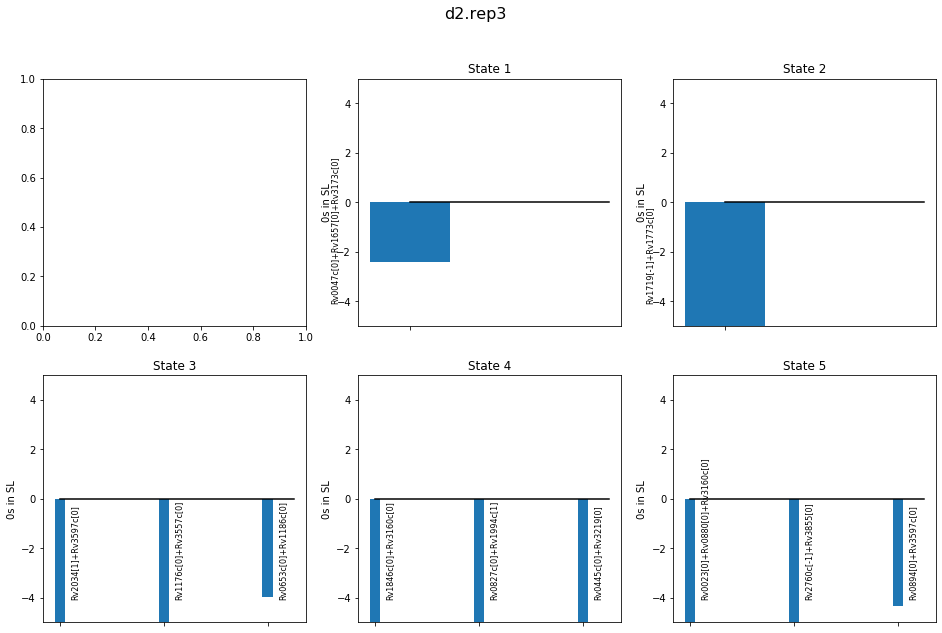

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


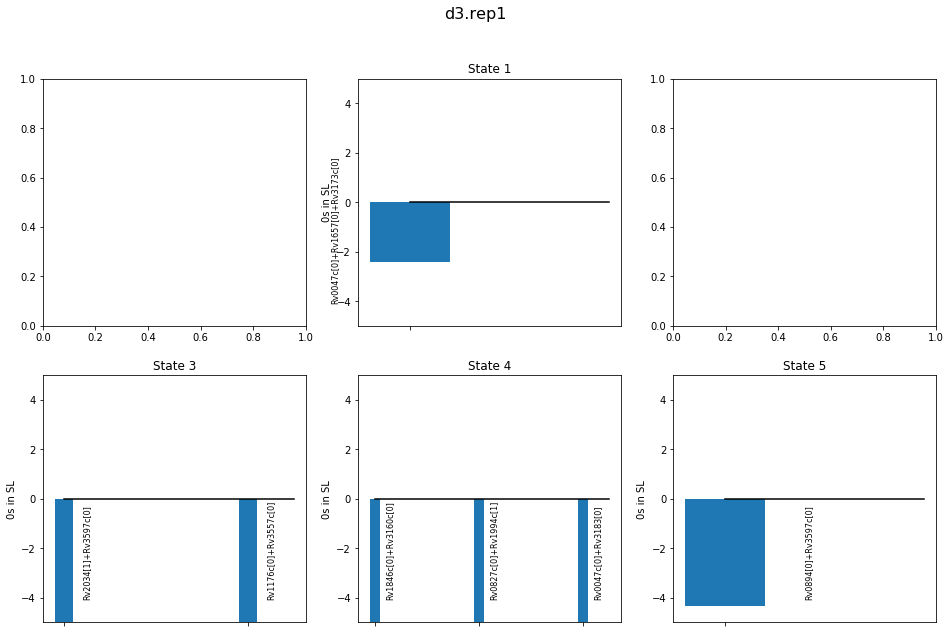

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


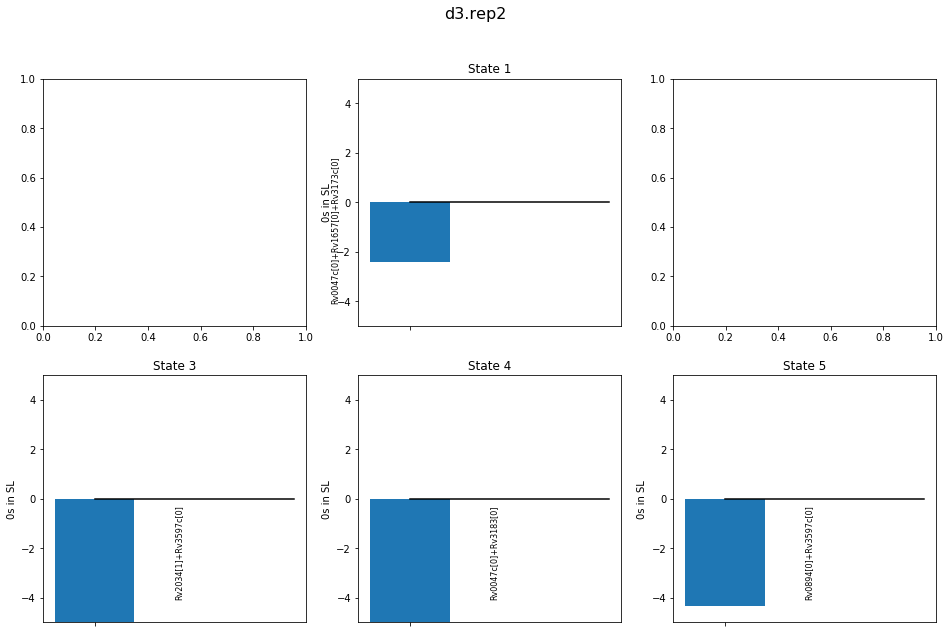

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


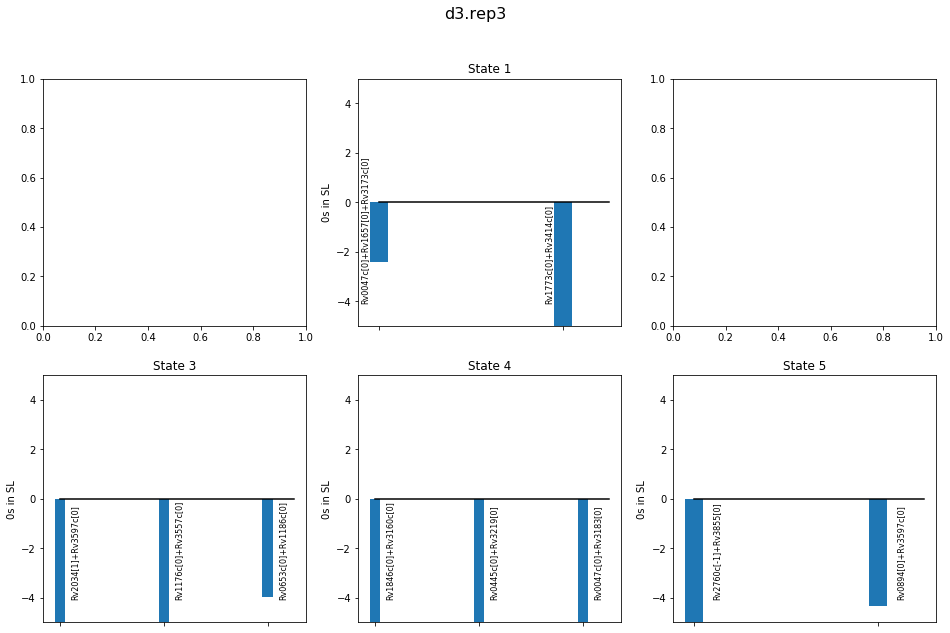

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


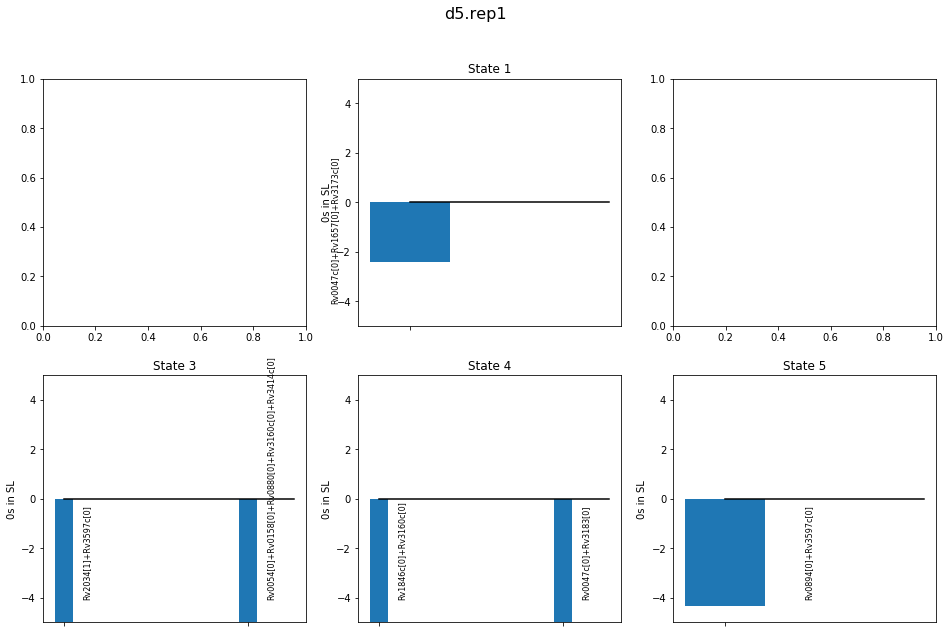

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


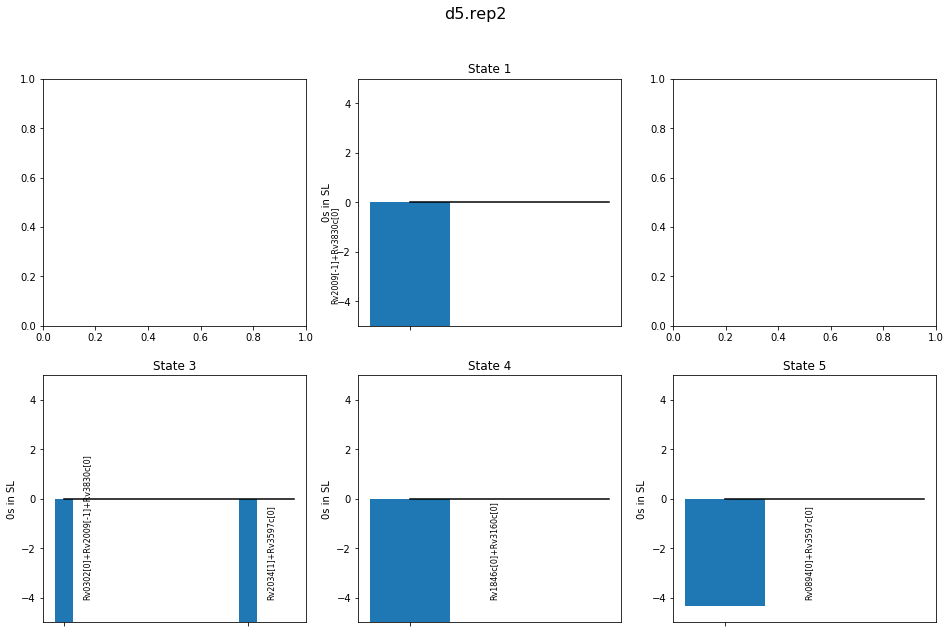

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


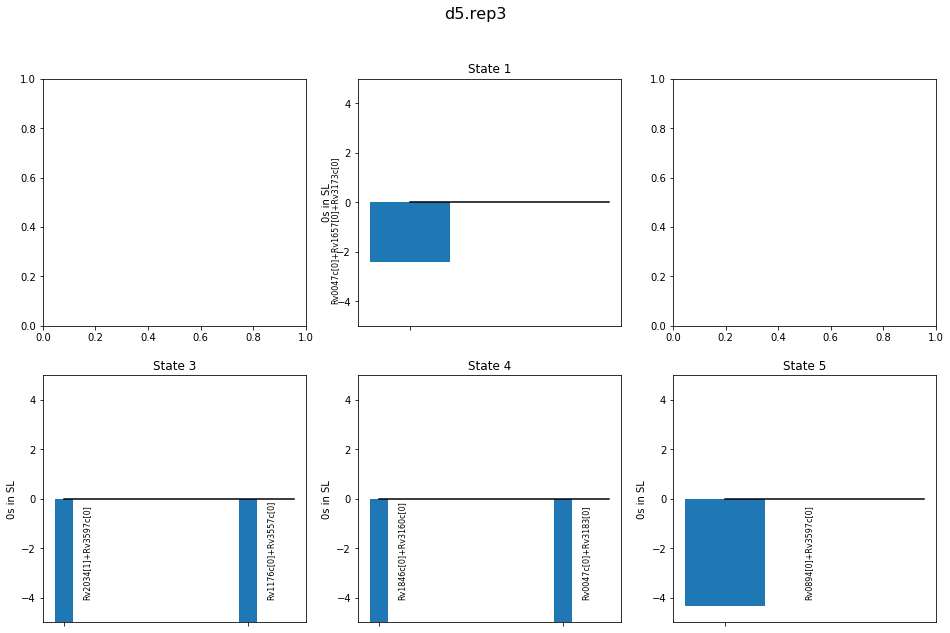

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


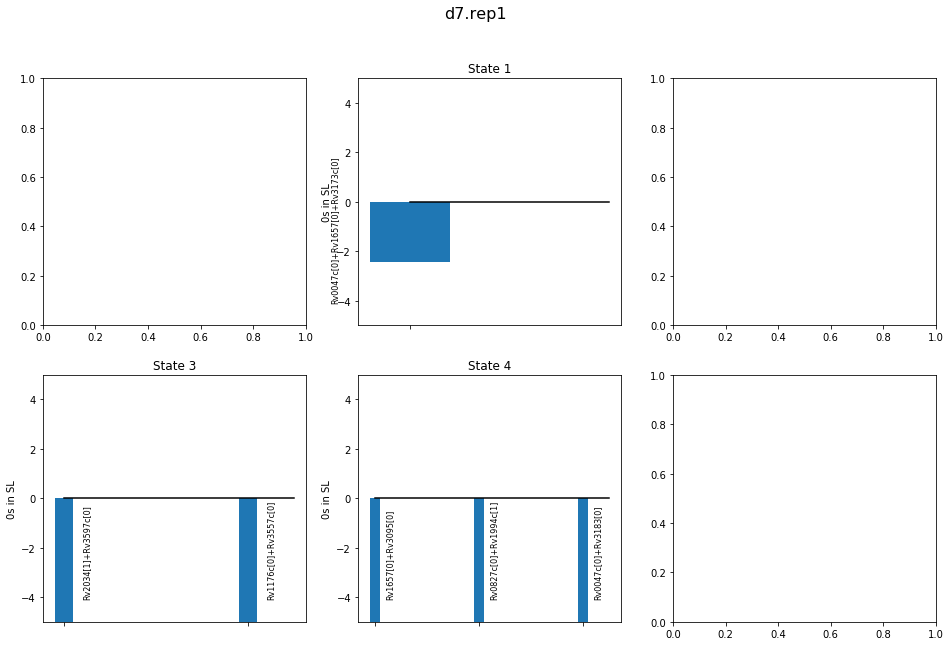

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


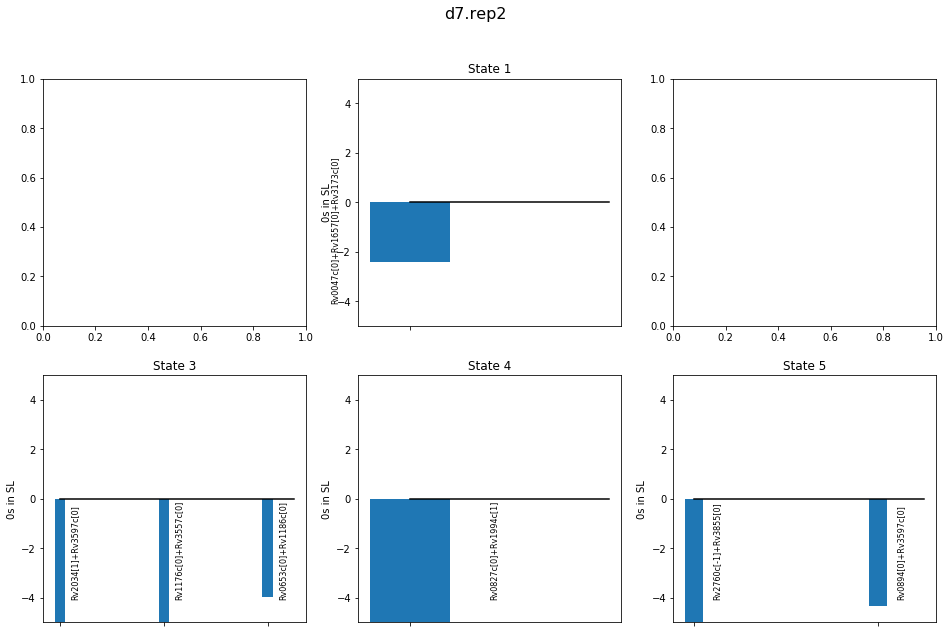

***No fset found that is consistent with the feature vector.
***No fset found that is consistent with the feature vector.


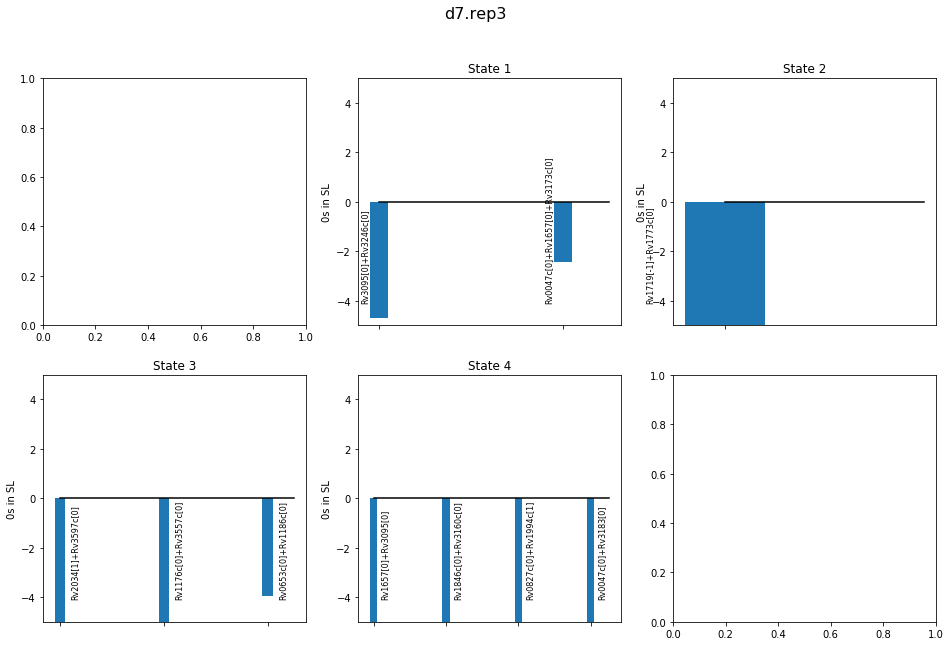

***No fset found that is consistent with the feature vector.


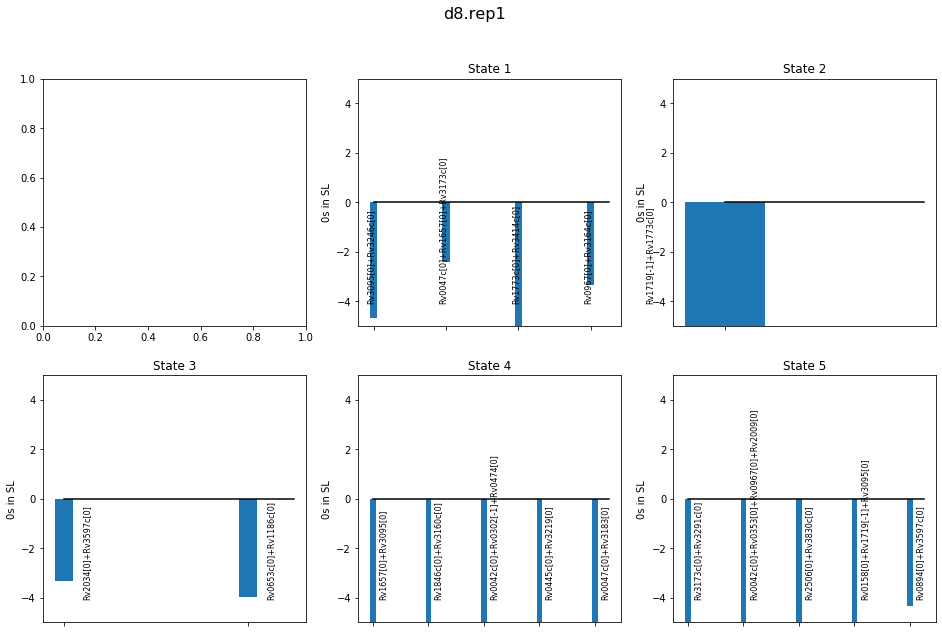

***No fset found that is consistent with the feature vector.


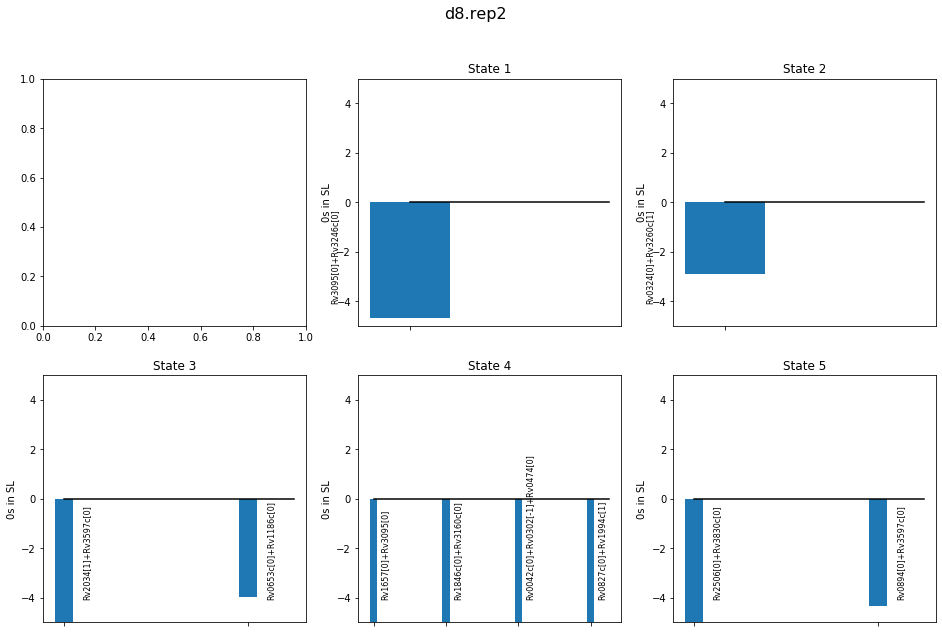

***No fset found that is consistent with the feature vector.


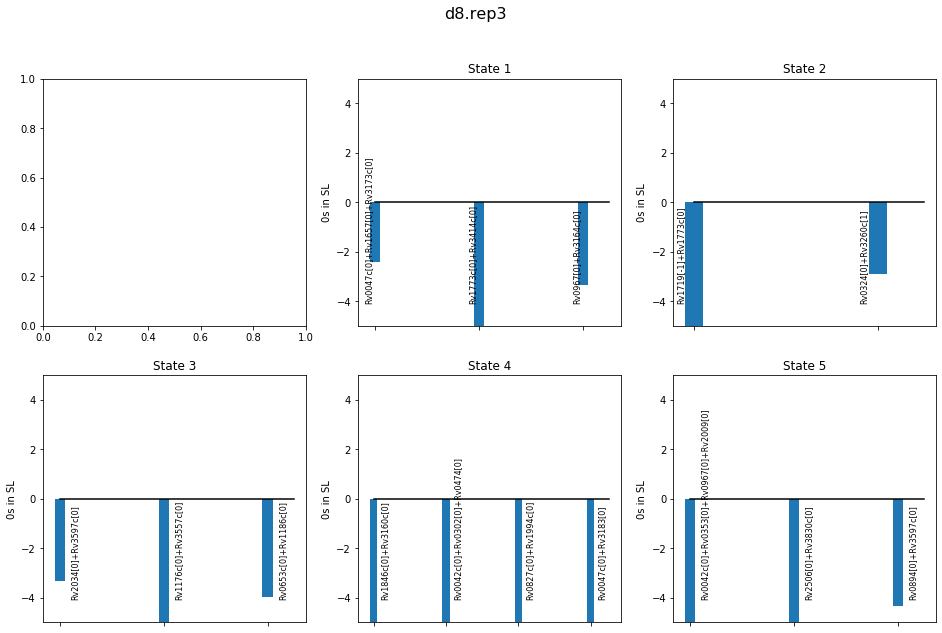

In [15]:
sorted_index = sorted(DF_GALAGAN.index.tolist(), key=lambda v: float(int(v[1]) + 0.1*int(v[6])))
for instance in sorted_index:
    ser_X = DF_GALAGAN.loc[instance]
    fullProfile(ser_X, title=instance, num_fset=15)

# AW Data

# Gene Analysis


In [16]:
def reportGO(genes):
    df = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
    result = []
    for gene in genes:
        if gene in df.index.tolist():
            result.append('"%s: %s"\n' % (gene, df.loc[gene, "GO_Term"]))
        else:
            result.append('"%s: no description"\n' % gene)
    return result
genes = ["Rv3095", "Rv3246c", "Rv2009", "Rv3830c", "Rv0602c", "Rv1956", "Rv3249c"]
print("\n".join(reportGO(genes)))

"Rv3095: no description"

"Rv3246c: protein phosphorylation---growth of symbiont in host---positive regulation of transcriptionDNA-templated---plasma membrane"

"Rv2009: response to hypoxia---positive regulation of growth"

"Rv3830c: transcription regulatory region sequence-specific DNA binding---DNA-binding transcription factor activity---cytosol"

"Rv0602c: negative regulation of phosphorelay signal transduction system---phosphorelay response regulator activity---plasma membrane"

"Rv1956: response to hypoxia---regulation of fatty acid metabolic process---negative regulation of transcriptionDNA-templated---negative regulation of growth---positive regulation of growth---protein binding"

"Rv3249c: transcription regulatory region sequence-specific DNA binding---DNA-binding transcription factor activity---cytosol"



In [17]:
PROVIDER.df_go_terms.head()

,GENE_ID,GO_Term
0,P9WKY5,host cell nucleus
1,Rv0001,DNA replication initiation---dephosphorylation...
2,Rv0002,extracellular region---cell wall
3,Rv0003,double-strand break repair---cytosol---plasma ...
4,Rv0005,DNA topological change---growth---magnesium io...


In [18]:
ser = pd.Series(reportGO(PROVIDER.tfs))
ser.to_csv("trn_report.csv")

In [19]:
df = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
df.loc["Rv0674", :]

GO_Term    growth---negative regulation of transcriptionD...
Name: Rv0674, dtype: object